<a href="https://colab.research.google.com/github/1900690/removebg-semantic-image-making/blob/main/%E8%83%8C%E6%99%AF%E3%81%A8%E5%90%88%E6%88%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#ライブラリをインポート(機能を使えるようにする)
import shutil
import os

file_name ="ok_mask_segmentation.zip"

if os.path.exists('/content/foward'):
    shutil.rmtree("/content/foward")

#データを解凍
shutil.unpack_archive('/content/'+file_name, '/content/')
os.rename('/content/'+os.path.splitext(file_name)[0]+'/', '/content/foward/')
#zipを消す
os.remove('/content/'+file_name)

In [2]:
import shutil
import os

file_name ="syakuyaku500_20250205174747.zip"

if os.path.exists('/content/back'):
    shutil.rmtree("/content/back")

#データを解凍
shutil.unpack_archive('/content/'+file_name, '/content/')
os.rename('/content/'+os.path.splitext(file_name)[0]+'/', '/content/back/')
#zipを消す
os.remove('/content/'+file_name)

FileNotFoundError: [Errno 2] No such file or directory: '/content/syakuyaku500_20250205174747/' -> '/content/back/'

In [ ]:
shutil.rmtree("/content/.ipynb_checkpoints")

In [ ]:
#@title 事前準備
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def rotate(img, angle, scale):
    """
    画像を回転（反転）させる
    [in]  img:   回転させる画像
    [in]  angle: 回転させる角度
    [in]  scale: 拡大率
    [out] 回転させた画像
    """

    size = img.shape[:2]
    mat = cv2.getRotationMatrix2D((size[0] // 2, size[1] // 2), angle, scale)
    return cv2.warpAffine(img, mat, size, flags=cv2.INTER_CUBIC)


def rotateR(img, level=[-10, 10], scale=1.5):
    """
    ランダムに画像を回転させる
    [in]  img:   回転させる画像
    [in]  level: 回転させる角度の範囲
    [out] 回転させた画像
    [out] 回転させた角度
    """

    angle = np.random.randint(level[0], level[1])
    return rotate(img, angle, scale), angle

def paste(fg, bg, mask_flg=True, random_flg=True):
    """
    背景に前景を重ね合せる
    [in]  fg:         重ね合せる背景
    [in]  bg:         重ね合せる前景
    [in]  mask_flg:   マスク処理を大きめにするフラグ
    [in]  random_flg: 前景をランダムに配置するフラグ
    [out] 重ね合せた画像
    """

    # Load two images
    img1 = bg.copy()
    if random_flg:# ランダム回転
        img2, _ = rotateR(fg, [-90, 90], 1.0)
    else:
        img2 = fg.copy()

    # I want to put logo on top-left corner, So I create a ROI
    w1, h1 = img1.shape[:2]
    w2, h2 = img2.shape[:2]
    if random_flg:# ランダム移動
        x = np.random.randint(0, w1 - w2 + 1)
        y = np.random.randint(0, w1 - w2 + 1)
    else:
        x = 0
        y = 0

    # Ensure the ROI dimensions are within the background image
    x = max(0, min(x, w1 - w2))
    y = max(0, min(y, h1 - h2))


    roi = img1[x:x + w2, y:y + h2]

    # Now create a mask of logo and create its inverse mask also
    mask = img2[:, :, 3]
    ret, mask_inv = cv2.threshold(
        cv2.bitwise_not(mask),
        200, 255, cv2.THRESH_BINARY
    )

    if mask_flg:# 縁を膨張・収縮で作成（膨張大きめ）
        kernel1 = np.ones((5, 5), np.uint8)
        kernel2 = np.ones((3, 3), np.uint8)
        mask_inv = cv2.dilate(mask_inv, kernel1, iterations=1)
        mask_inv = cv2.erode(mask_inv, kernel2, iterations=1)

    # Now black-out the area of logo in ROI
    img1_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

    # Take only region of logo from logo image.
    img2_fg = cv2.bitwise_and(img2, img2, mask=mask)

    # Resize img2_fg to match img1_bg if necessary
    if img1_bg.shape != img2_fg.shape:
        img2_fg = cv2.resize(img2_fg, (img1_bg.shape[1], img1_bg.shape[0]))

    # Ensure both images have the same number of channels
    if img1_bg.shape[2] != img2_fg.shape[2]:
        # Convert img2_fg to have the same number of channels as img1_bg
        img2_fg = cv2.cvtColor(img2_fg, cv2.COLOR_BGRA2BGR)  # Assuming img2_fg has 4 channels (BGRA)


    # Put logo in ROI and modify the main image
    dst = cv2.add(img1_bg, img2_fg)
    img1[x:x + w2, y:y + h2] = dst
    return img1

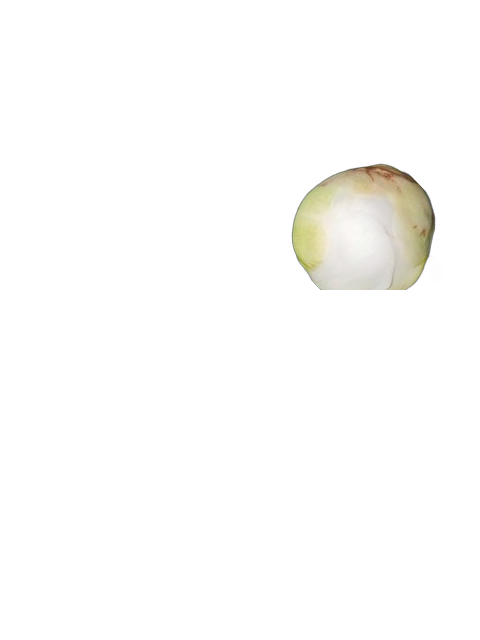

In [ ]:
import glob
import os
import random
import numpy as np


file_list_fimg = sorted(glob.glob('/content/foward/*.png'))
file_list_bimg = sorted(glob.glob('/content/back/*.jpg'))


if os.path.exists('/content/output'):
    shutil.rmtree("/content/output")
if not os.path.exists('/content/output'):
    os.makedirs('/content/output')

count=100#画像の枚数

for i in list(range(count)):
  fimg=random.choice(file_list_fimg)
  foward_image=cv2.imread(fimg, -1)

  if not os.path.exists('/content/back'):
    #黒背景に重ねる場合
    back_image=np.zeros((640,480,foward_image.shape[2]),np.uint8)
  else:
    bimg=random.choice(file_list_bimg)
    back_image=cv2.imread(bimg, -1)

  img = paste(
      foward_image,# 前景
      back_image,# 背景
      True,#縁膨張フラグ、
      True,#ランダム回転・移動フラグ
  )
  if not os.path.exists('/content/back'):
    cv2.imwrite('/content/output/black_'+os.path.splitext(os.path.basename(fimg))[0]+str(i).zfill(3)+'.jpg', img)
  else:
    cv2.imwrite('/content/output/'+os.path.splitext(os.path.basename(bimg))[0]+'_'+os.path.splitext(os.path.basename(fimg))[0]+str(i).zfill(3)+'.jpg', img)

cv2_imshow(img)

In [ ]:
#@markdown 作ったファイルをダウンロード
import shutil
import os
from google.colab import files

shutil.make_archive('/content/NGtest', 'zip', '/content/output')

'/content/NGtest.zip'

#指定の位置に合成

In [15]:
import pandas as pd

df = pd.read_csv('/content/csv/annotations.csv', usecols=['Name', 'x1', 'y1', 'x2', 'y2'])
print(df)

           Name   x1   y1   x2   y2
0   001 (2).jpg  113  281  271  447
1   003 (2).jpg  140  248  286  400
2   004 (2).jpg  170  277  296  398
3   005 (2).jpg  173  154  332  307
4   008 (2).jpg  220  169  378  325
..          ...  ...  ...  ...  ...
95  106 (3).jpg  179  142  383  324
96  107 (2).jpg   24   99  376  422
97   60 (1).jpg    1  344   78  508
98   60 (2).jpg   12  101  338  464
99   60 (3).jpg  197   58  472  309

[100 rows x 5 columns]


In [40]:
import glob
import os

img_name = sorted(glob.glob('/content/foward/*.png'))
test = os.path.basename(img_name[0])
filtered_df = df[df['Name'].str.contains(test[:4])]  # Store the filtered DataFrame
print(filtered_df)
dx=(filtered_df['x1']+filtered_df['x2'])/2
dy=(filtered_df['y1']+filtered_df['y2'])/2
print(dx)
print(dy)


          Name   x1   y1   x2   y2
1  003 (2).jpg  140  248  286  400
1    213.0
dtype: float64
1    324.0
dtype: float64


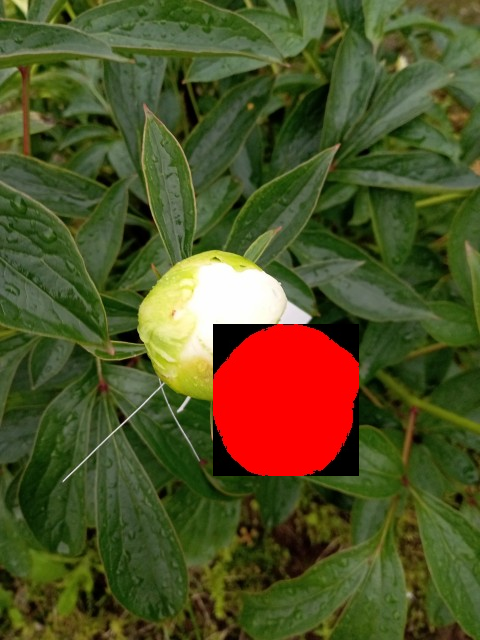

In [49]:
import cv2
from google.colab.patches import cv2_imshow

fore_img = cv2.imread('/content/foward/003 (2)_0.png')
back_img = cv2.imread('/content/original/003 (2).jpg')

dx=int(dx) # Directly cast dx to an integer
dy=int(dy) # Directly cast dy to an integer
h, w = fore_img.shape[:2]
back_img[dy:dy+h, dx:dx+w] = fore_img

cv2_imshow(back_img)

#★先に背景剛性が必要